# Create an interactive window to refine masks in SAM

In [1]:
#Import libraries
import time
import threading
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from ipywidgets import interact, IntSlider, HBox, VBox, Text, Button

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")
if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

## Setup directories
sam_dir="/mmfs1/cm/shared/apps_local/sam2"
img_dir="/scratch/SDSMT.LOCAL/bscott/images"
cell_dir="/scratch/SDSMT.LOCAL/bscott/Cropped/ch0"
checkpoint = sam_dir+"/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
device = torch.device("cuda")
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

using device: cuda


In [2]:
%matplotlib widget

In [3]:
plt.close('all')

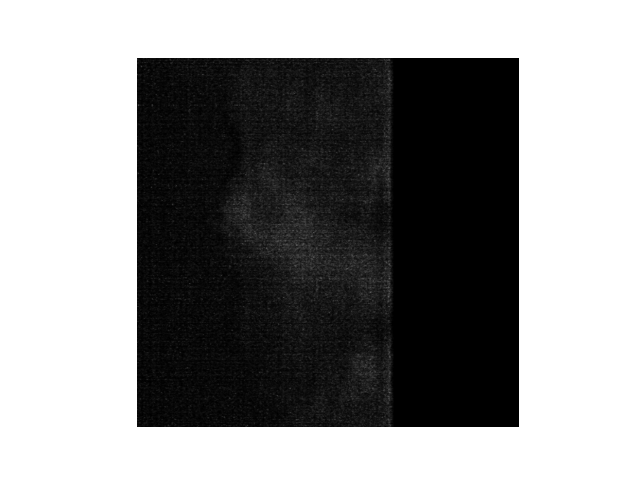

In [5]:
# Load the TIFF file
tiff_file = Image.open(cell_dir + '/cell2_CamB_ch0_stack0000_488nm_0000000msec_0014157451msecAbs_decon.tif')
num_pages = tiff_file.n_frames

# Dictionaries to store points for each page
points_per_page = {i: [] for i in range(num_pages)}

# Continuous scroll state and speed
scrolling = False
animation_running = False  # State for animation
scroll_speed = 0.05  # Adjust this for faster/slower scrolling
animation_speed = 0.05  # Set interval for animated scrolling

# Create figure and axes
fig, ax = plt.subplots()
img_display = ax.imshow(np.zeros((10, 10)), cmap="gray")  # Placeholder initial image
ax.axis('off')
current_page = 0  # Track the current page

# Helper function to find the closest point
def find_closest_point(points, x, y):
    distances = [(i, np.sqrt((px - x)**2 + (py - y)**2)) for i, (px, py, _) in enumerate(points)]
    closest_index = min(distances, key=lambda item: item[1])[0] if distances else None
    return closest_index

# Event handler for mouse clicks
def on_click(event):
    if event.inaxes == ax:
        x, y = int(event.xdata), int(event.ydata)

        if event.key == 'shift':  # Check if Shift key is pressed
            closest_index = find_closest_point(points_per_page[current_page], x, y)
            if closest_index is not None:
                points_per_page[current_page].pop(closest_index)
        
        elif event.button == 1:  # Left-click for positive point
            points_per_page[current_page].append((x, y, 1))

        elif event.button == 3:  # Right-click for negative point
            points_per_page[current_page].append((x, y, 0))

        # Update the figure
        show_page(current_page)
        mask=segment(tiff_file,points_per_page,seg_index)

        #masks, scores, logits = segment(tiff_file, points_per_page, page_index)
        #fig.canvas.draw_idle()
        #return masks, scores, logits



# Function to update the display to a specific page
def show_page(page_index):
    global current_page
    current_page = page_index

    tiff_file.seek(page_index)
    img_array = np.array(tiff_file)

    # Update the image display without opening a new figure
    ax.clear()
    ax.imshow(img_array, cmap="gray")
    ax.axis('off')

    # Draw markers for the current page
    for (x, y, ind) in points_per_page[page_index]:
        if ind == 0:
            plt_type='ro'
        elif ind == 1:
            plt_type='go'
        ax.plot(x, y, plt_type)

    # Update the slider and text box
    page_slider.value = page_index
    page_text.value = str(page_index)
    fig.canvas.draw()

def segment(tiff_file,page_points,page_index):
    tiff_file.seek(page_index)
    img_array = np.array(tiff_file)
    # Ensure the array has three dimensions
    if img_array.ndim == 2:  # Grayscale image (H, W)
        img_array = np.stack([img_array] * 3, axis=-1)  # Replicate the grayscale channel into RGB
    
    predictor.set_image(img_array.astype(np.float32))
    
    # Labels 1 (foreground) 0 (background)
    input_point = np.array([[p[0], p[1]] for p in page_points[page_index]])  # Extract (x, y)
    input_label = np.array([p[2] for p in page_points[page_index]])          # Extract labels
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    
    # Proceed with just the highest scoring mask.
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    mask, score, _ = predictor.predict(
       point_coords=input_point,
       point_labels=input_label,
       mask_input=mask_input[None, :, :],
       multimask_output=False,
    )
    show_masks(img_array, mask, score, point_coords=input_point, input_labels=input_label, borders=True)
    return mask
    

# Continuous scrolling function
def continuous_scroll(direction):
    global scrolling
    scrolling = True
    while scrolling:
        if direction == 'next' and current_page < num_pages - 1:
            show_page(current_page + 1)
        elif direction == 'prev' and current_page > 0:
            show_page(current_page - 1)
        else:
            break
        time.sleep(scroll_speed)

# Start continuous scrolling on key press
def on_key_press(event):
    if event.key == 'n':  # Start scrolling forward
        threading.Thread(target=continuous_scroll, args=('next',)).start()
    elif event.key == 'p':  # Start scrolling backward
        threading.Thread(target=continuous_scroll, args=('prev',)).start()

# Stop scrolling on key release
def on_key_release(event):
    global scrolling
    if event.key in ('n', 'p'):
        scrolling = False

# Animation function to loop through pages
def animate_pages():
    global current_page, animation_running
    while animation_running:
        next_page = (current_page + 1) % num_pages
        show_page(next_page)
        time.sleep(animation_speed)

# Toggle animation on button click
def toggle_animation(button):
    global animation_running
    if animation_running:
        animation_running = False
        button.description = "Start Animation"
    else:
        animation_running = True
        button.description = "Stop Animation"
        threading.Thread(target=animate_pages).start()

# Interactive slider, text box, and animation button for page navigation
page_slider = IntSlider(value=0, min=0, max=num_pages - 1, step=1, description="Page:")
page_text = Text(value="0", description="Go to Page:")
animate_button = Button(description="Start Animation")
np.random.seed(3)

# Sync slider and text box
def on_slider_change(change):
    show_page(change.new)

def on_text_change(change):
    try:
        page_num = int(change['new'])
        if 0 <= page_num < num_pages:
            show_page(page_num)
    except ValueError:
        pass

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=20):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
        
# Connect event handlers
page_slider.observe(on_slider_change, names='value')
page_text.observe(on_text_change, names='value')
fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key_press)
fig.canvas.mpl_connect('key_release_event', on_key_release)
animate_button.on_click(toggle_animation)

# Layout for slider, text input, and animation button
controls = HBox([page_slider, page_text, animate_button])

# Display only the controls and the existing figure canvas
display(VBox([controls, fig.canvas]))

# Show initial page
show_page(0)


In [6]:
!nvidia-smi

Tue Nov 19 16:51:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:17:00.0 Off |                    0 |
| N/A   34C    P0               64W / 300W|  45125MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
def segment(tiff_file,page_points,page_index):
    tiff_file.seek(page_index)
    img_array = np.array(tiff_file)
    # Ensure the array has three dimensions
    if img_array.ndim == 2:  # Grayscale image (H, W)
        img_array = np.stack([img_array] * 3, axis=-1)  # Replicate the grayscale channel into RGB
    
    predictor.set_image(img_array.astype(np.float32))
    
    # Labels 1 (foreground) 0 (background)
    input_point = np.array([[p[0], p[1]] for p in page_points[page_index]])  # Extract (x, y)
    input_label = np.array([p[2] for p in page_points[page_index]])          # Extract labels
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    
    # Proceed with just the highest scoring mask.
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    mask, scores, _ = predictor.predict(
       point_coords=input_point,
       point_labels=input_label,
       mask_input=mask_input[None, :, :],
       multimask_output=False,
    )
    show_masks(img_array, mask, scores, point_coords=input_point, input_labels=input_label, borders=True)
    return mask

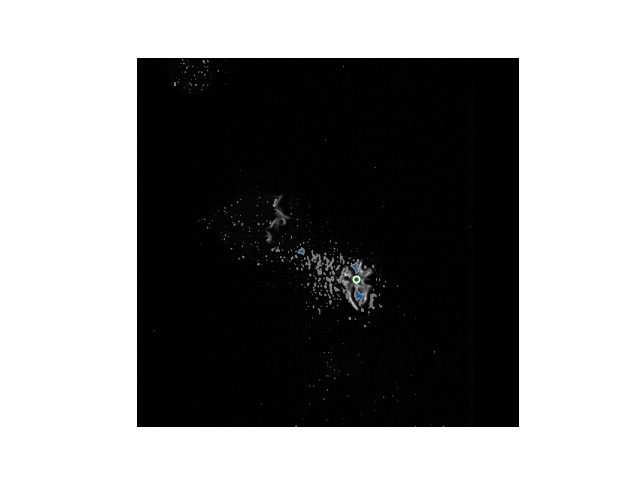

In [8]:
seg_index=106
fig2, ax2 = plt.subplots()
#img_display = ax2.imshow(np.zeros((10, 10)), cmap="gray")  # Placeholder initial image
tiff_file.seek(seg_index)
img_array = np.array(tiff_file)
# Update the image display without opening a new figure
ax2.clear()
ax2.imshow(img_array, cmap="gray")
ax2.axis('off')
mask=segment(tiff_file,points_per_page,seg_index)